Run the following code to import the required packages:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor

%matplotlib inline

### Feature Selection
In our previous case, there was only one dependent variable. If there is more than one, we might use multiple linear regression.

We will use this [simple survey data](http://www.ats.ucla.edu/stat/examples/chp/p054.txt) to demonstrate a few basic features of ***seaborn*** and how it might be used for regression.

The dataset is simply the results of a survey where the question responses are all numeric.  This leads to 6 numeric independent variable (predictor) fields and 1 numeric dependent variable (response) field.  The predictors are labeled ***X<sub>i</sub>*** and the response is labeled ***Y***.

Let's load the dataset in using ***pandas*** and take a look at it.

In [2]:
df = pd.read_csv('https://stats.idre.ucla.edu/wp-content/uploads/2016/02/p054.txt', sep="\t")
df.columns = df.columns.str.strip()
df.head()



,Y,X1,X2,X3,X4,X5,X6
0,43,51,30,39,61,92,45
1,63,64,51,54,63,73,47
2,71,70,68,69,76,86,48
3,61,63,45,47,54,84,35
4,81,78,56,66,71,83,47


We see that the data has 30 responses with 7 fields (6 independent, 1 dependent) each. Let's use pandas to check out the correlations between the different variables.

In [3]:
df.corr()

,Y,X1,X2,X3,X4,X5,X6
Y,1.000000,0.825418,0.426117,0.623678,0.590139,0.156439,0.155086
X1,0.825418,1.000000,0.558288,0.596736,0.669197,0.187714,0.224580
X2,0.426117,0.558288,1.000000,0.493331,0.445478,0.147233,0.343293
X3,0.623678,0.596736,0.493331,1.000000,0.640314,0.115965,0.531620
X4,0.590139,0.669197,0.445478,0.640314,1.000000,0.376883,0.574186
X5,0.156439,0.187714,0.147233,0.115965,0.376883,1.000000,0.283343
X6,0.155086,0.224580,0.343293,0.531620,0.574186,0.283343,1.000000


We notice that some of the variables (such as X1 and X3) are highly correlated.  This is something we might want to take into consideration later.  When 2 predictor variables are highly correlated this is called [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity) and it is something we want to watch out for as it can destabilize our model.  In the extreme case, when 2 predictors are perfectly correlated then there is absolutely nothing gained by making both variables part of our regression.

Another thing we notice is that some variables are highly correlated with our target variable. We see that X1 and Y are highly correlated (r=0.825) whereas X6 and Y are less so (0.155). If we can only choose a few features to add to our model, we will probably prefer to choose those with the highest correlation. 

We can view the highest correlations by sorting them:

In [4]:
df.corr()['Y'].sort_values(ascending=False)

Y     1.000000
X1    0.825418
X3    0.623678
X4    0.590139
X2    0.426117
X5    0.156439
X6    0.155086
Name: Y, dtype: float64

Remember that we also need to make sure that there is a linear relationship between the feature and the target variable, or else we might need to perform a transformation. Let's look at the shape of the scatterplots here:

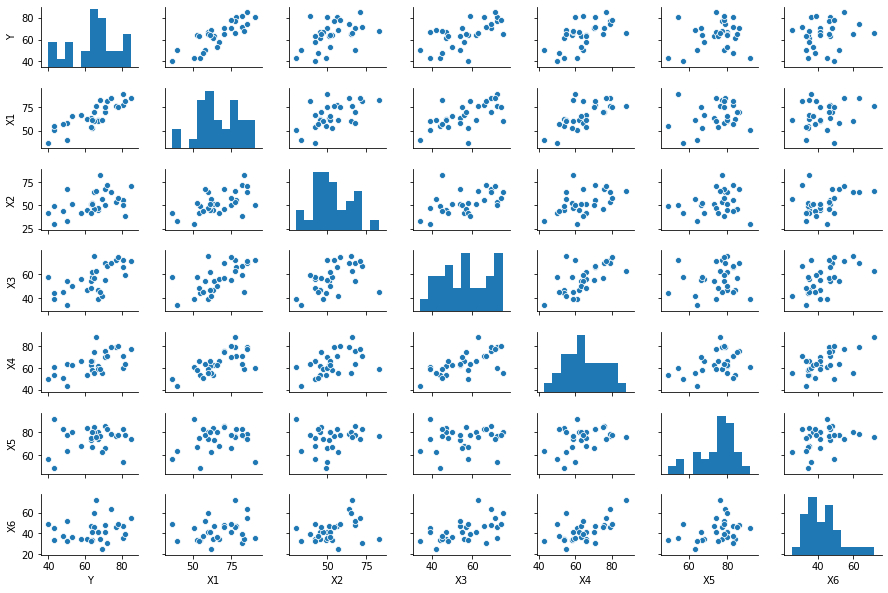

In [5]:
sns.pairplot(df, height = 1.2, aspect=1.5)

### Adjusted R-Squared
Recall that ***R<sup>2</sup>*** is the square of the correlation coefficient and represents the estimated percentage of the variance in our target variable ***Y*** that can be explained by our regression model. The only drawback of R2 is that if new predictors (X) are added to our model, R2 only increases or remains constant but it never decreases. We can not judge that by increasing complexity of our model, are we making it more accurate?

That is why we use “Adjusted R-Square”.

The Adjusted R-Square is the modified form of R-Square that has been adjusted for the number of predictors in the model. The adjusted R-Square only increases if the new term improves the model accuracy. ***Adjusted R<sup>2</sup>*** also penalizes for things such as large coefficients and extra variables to try and limit ***overfitting*** so it is often a better measure of model efficacy.  Here is the formula:

$R^2  \text{adjusted}=1-\frac{(1-R^2)(N-1)}{N-p-1}$

Let's run a linear regression model:

In [6]:
# Create an empty model
model = LinearRegression()
# Choose the predictor variables, here all but the first which is the response variable
# This model is analogous to the Y ~ X1 + X2 + X3 + X4 + X5 + X6 model
X = df.iloc[:, 1:]
# Choose the response variable(s)
y = df.iloc[:, 0]
# Fit the model to the full dataset
model.fit(X, y)
# Print out the R^2 for the model against the full dataset
print(f"R^2: {model.score(X,y)}")
print(f"Adjusted R^2: {1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)}")

R^2: 0.7326019925311491
Adjusted R^2: 0.6628459905827533


Notice in the sorted list above that X5 and X6 had very low correlations with price (0.156439 and 0.155086). Let's see what happens to our adjusted R^2 if we drop those features and rerun our linear model. We'll find that our adjusted R^2 actually increases slightly!

In [7]:
df = df.drop(columns = ['X5', 'X6'])

# Create an empty model
model = LinearRegression()
# Choose the predictor variables, here all but the first which is the response variable
# This model is analogous to the Y ~ X1 + X2 + X3 + X4 model
X = df.iloc[:, 1:]
# Choose the response variable(s)
y = df.iloc[:, 0]
# Fit the model to the full dataset
model.fit(X, y)
# Print out the R^2 for the model against the full dataset
print(f"R^2: {model.score(X,y)}")
print(f"Adjusted R^2: {1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)}")

R^2: 0.7152237146514394
Adjusted R^2: 0.6696595089956696


So we now have a linear model, but what exactly is it? Let's print out the coefficients:

In [8]:
# print out intercept
print(model.intercept_)
# print out other coefficients
print(model.coef_)

11.833542828302214
[ 0.69114872 -0.10288557  0.24633061 -0.02551155]


This means that our model is given by:

$\hat{y} = 11.833 + 0.691x_1 - 0.103 x_2 + 0.246 x_3 - 0.026 x_4$

What would we predict y to be if $x_1=x_2=x_3=x_4=1$? Approximately 12.6.

In [9]:
model.predict([[1,1,1,1]])

array([12.64262504])